In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pyasn
from iso3166 import countries

In [2]:
from numpy.random import uniform, normal, poisson, binomial
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf 
import statsmodels.api as sm

# DATA PREPARATION

### Abuse report data

In [3]:
data = pd.read_csv("merge_result.csv")
data

,Unnamed: 0,id,dateadded,url,url_status,threat,tags,urlhaus_link,reporter,AS_Number
0,0,544165,9/17/2020 10:10,http://115.98.1.103:56034/Mozi.a,offline,malware_download,None,https://urlhaus.abuse.ch/url/544165/,lrz_security,17488
1,1,544163,9/17/2020 10:10,http://115.97.82.185:47119/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544163/,lrz_security,17488
2,2,544164,9/17/2020 10:10,http://115.97.83.180:58110/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544164/,lrz_security,17488
3,3,544162,9/17/2020 10:10,http://115.98.145.51:60363/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544162/,lrz_security,17488
4,4,544161,9/17/2020 10:10,http://115.97.80.186:42284/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544161/,lrz_security,17488
...,...,...,...,...,...,...,...,...,...,...
108757,108757,435287,8/18/2020 0:04,http://14.157.58.114:35300/Mozi.m,offline,malware_download,Mozi,https://urlhaus.abuse.ch/url/435287/,Gandylyan1,4134
108758,108758,435286,8/18/2020 0:04,http://180.106.132.202:53524/Mozi.m,offline,malware_download,Mozi,https://urlhaus.abuse.ch/url/435286/,Gandylyan1,4134
108759,108759,435285,8/18/2020 0:04,http://36.105.58.7:38745/Mozi.m,offline,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/435285/,lrz_security,4134
108760,108760,435284,8/18/2020 0:03,http://johnsonlam.com/download/available_2mrDR...,online,malware_download,"doc,emotet,epoch1,heodo",https://urlhaus.abuse.ch/url/435284/,Cryptolaemus1,46015


### Reactspeed per country data

In [4]:
reactspeed = pd.read_csv("reactspeedURLhaus_inminutes.csv")
reactspeed.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8


## Average reactionspeed per country

In [5]:
speed_mean=reactspeed.groupby('Country').mean()['total_in_minutes'].to_frame()
speed_mean.columns = ['Reaction speed mean']
speed_mean=speed_mean.reset_index()
speed_mean.head()

,Country,Reaction speed mean
0,AE,50664.250000
1,AL,54086.846154
2,AM,120297.666667
3,AR,44259.701754
4,AT,26164.400000


## Number of malware URLs per country

In [6]:
reactspeed['URL count'] = reactspeed['Online'] + reactspeed['Offline']
reactspeed.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes,URL count
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3,1
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5,1
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7,1
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7,1
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8,1


In [7]:
url_count=reactspeed.groupby('Country').sum()['URL count'].to_frame()
url_count.columns=['URL count']
url_count=url_count.reset_index()
url_count.sort_values('URL count', ascending=False)

,Country,URL count
146,US,155472
64,IN,86436
30,CN,40651
38,DE,18656
124,RU,16896
...,...,...
59,HT,1
69,JM,1
155,YE,1
127,SD,1


## IP space

In [8]:
asndb = pyasn.pyasn("ipasn_20150113.dat")

In [9]:
#get AS prefixes
tes=asndb.get_as_prefixes(52715)
tes

{'177.84.20.0/22',
 '177.84.20.0/24',
 '177.84.21.0/24',
 '177.84.22.0/24',
 '177.84.23.0/24'}

In [10]:
#get IP space per prefix 2^(32-/n)
for i in tes:
    print(2**(32-(int(i.split('/')[-1]))))

256
256
1024
256
256


In [11]:
all_ip_space=[]

for row in range(len(reactspeed)):
    
    ip_space = 0
    asn = (reactspeed.iloc[row,1])
    
    if asn != 'None':
        
        prefixes = asndb.get_as_prefixes(asn)

        if prefixes is not None:
            for ip in prefixes:
                ip_space += 2**(32-(int(ip.split('/')[-1])))
            all_ip_space.append(ip_space)
        else:
            all_ip_space.append(0)
    else:
        all_ip_space.append(0)
        
len(all_ip_space)

4813

In [12]:
reactspeed['IP space']=all_ip_space
reactspeed.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes,URL count,IP space
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3,1,2048
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5,1,6400
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7,1,13312
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7,1,0
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8,1,76800


In [13]:
IP_space_ctr=reactspeed.groupby('Country').sum()['IP space'].to_frame().reset_index()
IP_space_ctr
IP_space_ctr.sort_values(by='IP space', ascending=False)

,Country,IP space
146,US,494189994
30,CN,383767296
71,JP,172025584
38,DE,157256250
75,KR,116083784
...,...,...
34,CV,0
154,XK,0
155,YE,0
126,SC,0


## Rule of Law Index

In [14]:
rol=pd.read_csv('Rule of Law Index.csv')
rol.head()

,Country Code,Rule of Law Index
0,AFG,0.36
1,ALB,0.50
2,DZA,0.49
3,AGO,0.43
4,ATG,0.63


In [15]:
Country=[]
for row in range(len(rol)):
    ctr=rol.iloc[row,0]
    ccode=countries.get(ctr).alpha2
    Country.append(ccode)
rol['Country']=Country
rol.head()

,Country Code,Rule of Law Index,Country
0,AFG,0.36,AF
1,ALB,0.50,AL
2,DZA,0.49,DZ
3,AGO,0.43,AO
4,ATG,0.63,AG


# MERGING OF DATA

In [16]:
factor=pd.merge(url_count,speed_mean,on='Country',how='inner')
factor

,Country,URL count,Reaction speed mean
0,AE,16,50664.250000
1,AL,38,54086.846154
2,AM,17,120297.666667
3,AR,531,44259.701754
4,AT,177,26164.400000
...,...,...,...
153,VU,4,36.000000
154,XK,3389,24367.000000
155,YE,1,587.000000
156,ZA,988,57874.634146


In [17]:
factor=pd.merge(factor,IP_space_ctr,on='Country',how='inner')
factor

,Country,URL count,Reaction speed mean,IP space
0,AE,16,50664.250000,9214208
1,AL,38,54086.846154,313600
2,AM,17,120297.666667,614656
3,AR,531,44259.701754,20933056
4,AT,177,26164.400000,4106368
...,...,...,...,...
153,VU,4,36.000000,14592
154,XK,3389,24367.000000,0
155,YE,1,587.000000,0
156,ZA,988,57874.634146,30727112


In [18]:
factor=pd.merge(factor,rol[['Country','Rule of Law Index']],on='Country',how='inner')
factor

,Country,URL count,Reaction speed mean,IP space,Rule of Law Index
0,AE,16,50664.250000,9214208,0.65
1,AL,38,54086.846154,313600,0.50
2,AR,531,44259.701754,20933056,0.58
3,AT,177,26164.400000,4106368,0.82
4,AU,1225,34194.742424,34648755,0.80
...,...,...,...,...,...
105,VE,73,92883.125000,4650752,0.27
106,VN,5159,33377.267857,32344096,0.49
107,XK,3389,24367.000000,0,0.54
108,ZA,988,57874.634146,30727112,0.59


# FACTOR ANALYSIS

Checking the skewness of data. Use log transformation for highliy skewed data (following Tajalizadehkhoob)

(array([57., 29., 12.,  4.,  3.,  2.,  1.,  0.,  1.,  1.]),
 array([3.910000e+02, 4.959590e+04, 9.880080e+04, 1.480057e+05,
        1.972106e+05, 2.464155e+05, 2.956204e+05, 3.448253e+05,
        3.940302e+05, 4.432351e+05, 4.924400e+05]),
 <a list of 10 Patch objects>)

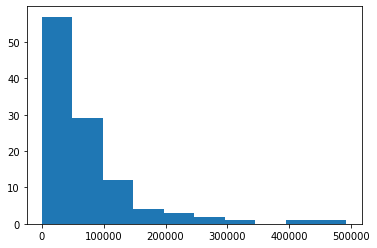

In [19]:
plt.hist(factor['Reaction speed mean'])

(array([102.,   3.,   1.,   2.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.00000000e+00, 4.94189994e+07, 9.88379988e+07, 1.48256998e+08,
        1.97675998e+08, 2.47094997e+08, 2.96513996e+08, 3.45932996e+08,
        3.95351995e+08, 4.44770995e+08, 4.94189994e+08]),
 <a list of 10 Patch objects>)

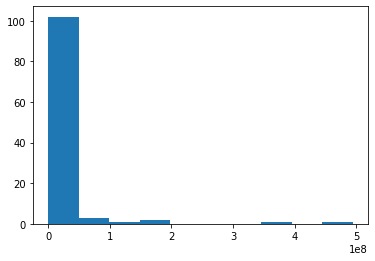

In [20]:
plt.hist(factor['IP space'])

(array([ 2.,  7., 16., 32., 15.,  9.,  8.,  6.,  9.,  6.]),
 array([0.27 , 0.333, 0.396, 0.459, 0.522, 0.585, 0.648, 0.711, 0.774,
        0.837, 0.9  ]),
 <a list of 10 Patch objects>)

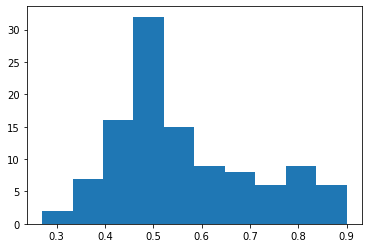

In [21]:
plt.hist(factor['Rule of Law Index'])

In [22]:
factor['log10(Reaction speed mean)']=np.log10(factor['Reaction speed mean'])
factor['log10(IP space+1)']=np.log10(factor['IP space']+1)
factor

,Country,URL count,Reaction speed mean,IP space,Rule of Law Index,log10(Reaction speed mean),log10(IP space+1)
0,AE,16,50664.250000,9214208,0.65,4.704702,6.964458
1,AL,38,54086.846154,313600,0.50,4.733092,5.496377
2,AR,531,44259.701754,20933056,0.58,4.646008,7.320833
3,AT,177,26164.400000,4106368,0.82,4.417711,6.613458
4,AU,1225,34194.742424,34648755,0.80,4.533959,7.539688
...,...,...,...,...,...,...,...
105,VE,73,92883.125000,4650752,0.27,4.967937,6.667523
106,VN,5159,33377.267857,32344096,0.49,4.523451,7.509795
107,XK,3389,24367.000000,0,0.54,4.386802,0.000000
108,ZA,988,57874.634146,30727112,0.59,4.762488,7.487522


In [23]:
y=factor[['URL count']]
y

,URL count
0,16
1,38
2,531
3,177
4,1225
...,...
105,73
106,5159
107,3389
108,988


## First Model: 1 Factor - "Rule of Law Index"

In [24]:
x=factor[['Rule of Law Index']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

C:\Users\stell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  110
Model:                            GLM   Df Residuals:                      108
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.3134e+05
Date:                Mon, 05 Oct 2020   Deviance:                   1.8619e+06
Time:                        02:12:01   Pearson chi2:                 7.08e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.3174      0.006    987.921      0.000       6.305       6.330
Rule of Law Index     3.2865      0.010    337.162      0.000       3.267       3.306
=====================================================================================
"""

In [25]:
llfull=res.llf
llfull

-931343.8592164946

In [26]:
llnull=res.llnull
llnull

-986177.282831763

In [27]:
pseudor2=1-(llfull/llnull)
pseudor2

0.0556019942558571

## Second Model: 2 Factor - "Reaction speed mean" and "Rule of Law Index"

In [28]:
x=factor[['log10(Reaction speed mean)','Rule of Law Index']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  110
Model:                            GLM   Df Residuals:                      107
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2516e+05
Date:                Mon, 05 Oct 2020   Deviance:                   1.8496e+06
Time:                        02:12:01   Pearson chi2:                 6.95e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          4.5285      0.019    244.689      0.000       4.492       4.565
log10(Reaction speed mean)     0.3657      0.003    105.634      0.000       0.359       0.372
Rule of Law Index              3.4403      0.010    349.839      0.000       3.421       3.460
==============================================================================================
"""

In [29]:
llfull=res.llf
llfull

-925163.5489702844

In [30]:
llnull=res.llnull
llnull

-986177.282831763

In [31]:
pseudor2=1-(llfull/llnull)
pseudor2

0.06186893059053289

## Third Model: 3 Factor - "Reaction speed mean", "IP Space", "Rule of Law Index"

In [32]:
x=factor[['log10(Reaction speed mean)','log10(IP space+1)','Rule of Law Index']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  110
Model:                            GLM   Df Residuals:                      106
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.5105e+05
Date:                Mon, 05 Oct 2020   Deviance:                   7.0136e+05
Time:                        02:12:01   Pearson chi2:                 2.25e+10
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.4181      0.022   -198.571      0.000      -4.462      -4.374
log10(Reaction speed mean)    -0.5535      0.004   -123.038      0.000      -0.562      -0.545
log10(IP space+1)              2.2194      0.003    845.000      0.000       2.214       2.225
Rule of Law Index             -1.3581      0.012   -116.775      0.000      -1.381      -1.335
==============================================================================================
"""

In [33]:
llfull=res.llf
llfull

-351053.2909553311

In [34]:
llnull=res.llnull
llnull

-986177.282831763

In [35]:
pseudor2=1-(llfull/llnull)
pseudor2

0.6440261836621326